In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.1
IPython 7.0.1

numpy 1.15.3
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.1
statsmodels 0.9.0
sklearn 0.20.0

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 8f9dc62c30f1434fac9b6dba693b2fe05427d706


In [59]:
import csv
import pickle
import string
from collections import Counter, defaultdict
from functools import partial
from itertools import chain, count, product, zip_longest
from pathlib import Path
from typing import Any, Dict, List, Tuple, TypeVar, Iterable
from tqdm import tqdm_notebook

import numpy
import pandas
from more_itertools import chunked, seekable, sliced, windowed, take
from pandas import DataFrame
from scipy import stats
from scipy.sparse import csr_matrix
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline

## Часть 1. Подготовка нескольких обучающих выборок для сравнения

In [3]:
T = TypeVar('T')

def custom_windowed(iterable: Iterable[T], n: int, step: int) -> Iterable[List[T]]:
    iterable = list(iterable)
    for offset in range(0, len(iterable), step):
        yield iterable[offset:offset + n]

In [4]:
def prepare_sparse_train_set_window(
    path: Path, 
    session_length: int = 10,
    window_size: int = 10,
    field_names: List[str] = None,
    delimiter: str = ',',
) -> Tuple[csr_matrix, numpy.ndarray]:
    user_sessions: List[Tuple[int, Counter]] = [
        (int(csv_path.stem[-4:]), Counter(session))
        for csv_path in sorted(path.glob('*.csv'))
        for session in custom_windowed((
            row['site']
            for row in csv.DictReader(csv_path.open('rt'), fieldnames=field_names, delimiter=delimiter)
        ), n=session_length, step=window_size)
    ]
    
    # Assign an incremental ID to each unique site.
    site_ids: Dict[str, int] = dict(zip(set(chain.from_iterable(session for _, session in user_sessions)), count()))
        
    x = csr_matrix((
        [value for _, session in user_sessions for value in session.values()],  # values are visit counts
        (
            [
                i
                for i, (_, session) in enumerate(user_sessions)
                for value in session.values()
            ],  # row indices are session numbers
            [
                site_ids[site]
                for _, session in user_sessions
                for site in session
            ],  # column indices are site IDs
        ),
    ))
    y = numpy.array([user_id for user_id, _ in user_sessions])
    
    return x, y

Примените полученную функцию с параметрами `session_length=5` и `window_size=3` к игрушечному примеру. Убедитесь, что все работает как надо.

In [5]:
x_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(Path('3users'), session_length=5, window_size=3)

In [6]:
x_toy_s5_w3.todense()

matrix([[3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
        [2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3],
        [0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [7]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

Запустите созданную функцию 16 раз с помощью циклов по числу пользователей `num_users` (10 или 150), значениям параметра `session_length` (15, 10, 7 или 5) и значениям параметра `window_size` (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.

In [17]:
%%time

data_lengths = []

for users_number in [10, 150]:
    for window_size, session_length in tqdm_notebook(product([10, 7, 5], [15, 10, 7, 5]), desc=f'{users_number} users'):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            x, y = prepare_sparse_train_set_window(
                Path(f'{users_number}users'),
                session_length=session_length,
                window_size=window_size,
            )
            Path(f'x_{users_number}users_s{session_length}_w{window_size}.pkl').write_bytes(pickle.dumps(x))
            Path(f'y_{users_number}users_s{session_length}_w{window_size}.pkl').write_bytes(pickle.dumps(y))
            data_lengths.append(x.shape[0])


CPU times: user 52.8 s, sys: 1.45 s, total: 54.2 s
Wall time: 54.4 s


In [18]:
Path('answer2_1.txt').write_text(' '.join(map(str, data_lengths)))

103

## Часть 2. Первичный анализ данных, проверка гипотез

Считаем в `DataFrame` подготовленный на 1 неделе файл `train_data_10users.csv`. Далее будем работать с ним.

In [23]:
def prepare_train_set(path: Path, session_length: int = 10) -> Tuple[DataFrame, Dict[str, Tuple[int, int]]]:
    # List of visited sites per each user.
    user_sites: List[Tuple[int, List[str]]] = [
        (int(csv_path.stem[-4:]), [row['site'] for row in csv.DictReader(csv_path.open('rt'))])
        for csv_path in sorted(path.glob('*.csv'))
    ]
        
    # Count visits per each site.
    site_frequencies = Counter(chain.from_iterable(sites for _, sites in user_sites))
    
    # Assign an incremental ID to each unique site.
    site_ids: Dict[str, int] = dict(zip(site_frequencies, count(start=1)))
        
    frame = DataFrame([
        # User ID and each of `session_length` visited sites.
        {'user_id': user_id, **{
            # Assign `0` if session is too short.
            f'site_{i:02d}': site_ids.get(site, 0)
            for i, site in zip_longest(range(1, session_length + 1), session)
        }}
        for user_id, sites in user_sites
        for session in sliced(sites, session_length)  # split user's sites into sessions
    ], dtype=int)
    frequency_dict = {
        site: (site_id, site_frequencies[site]) 
        for site, site_id in site_ids.items()
    }
    return frame, frequency_dict

In [63]:
frame_10users, frequencies_10 = prepare_train_set(Path('10users'))

In [26]:
frame_10users.head()

,site_01,site_02,site_03,site_04,site_05,site_06,site_07,site_08,site_09,site_10,user_id
0,1,2,3,4,3,3,4,3,5,3,31
1,6,7,8,9,3,10,11,12,13,14,31
2,14,4,14,14,15,16,6,17,18,14,31
3,19,20,19,14,14,14,14,21,22,23,31
4,24,14,15,25,26,27,28,29,30,29,31


Распределение целевого класса:

In [28]:
frame_10users['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

In [39]:
unique_sites_series = pandas.Series([len(set(row[:-1])) for _, row in frame_10users.iterrows()])
unique_sites_series.value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

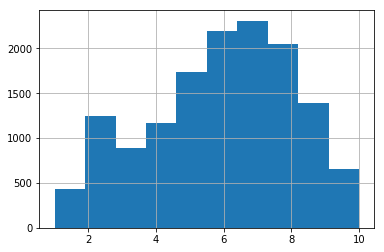

In [42]:
unique_sites_series.hist()

Распределено ли нормально число уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов (согласно критерию Шапиро-Уилка)?

In [48]:
w, p = stats.shapiro(unique_sites_series)
Path('answer2_2.txt').write_text('YES' if p > 0.05 else 'NO')

/Users/eigenein/GitHub/mipt-ya-ml-spec/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


2

Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% – одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.

In [53]:
p = stats.binom_test((unique_sites_series < 10).sum(), len(unique_sites_series), 0.95, 'greater')
Path('answer2_3.txt').write_text(str(p))

19

Каков 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт (из п. 3)?

In [62]:
left, right = proportion_confint((unique_sites_series < 10).sum(), len(unique_sites_series), method='wilson')
Path('answer2_4.txt').write_text(f'{left:.3} {right:.3}')

10

Каков 95% доверительный интервал для средней частоты появления сайта в выборке?

In [96]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    numpy.random.seed(random_seed)
    indices = numpy.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices]


def stat_intervals(stat, alpha=0.05):
    return numpy.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])


left, right = stat_intervals(get_bootstrap_samples(
    numpy.array(sorted([freq for _, freq in frequencies_10.values()], reverse=True)),
    len(frequencies_10),
).mean(axis=1))

In [97]:
left, right

(22.515245267657235, 35.763036841033994)

In [98]:
Path('answer2_5.txt').write_text(f'{left:.3} {right:.3}')

9